# Detect Delay shipping in the E-Commerce dataset

Data source: https://www.kaggle.com/datasets/prachi13/customer-analytics

In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score,accuracy_score,precision_score,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

# Understand the topic, find recall is benchmark

Company action after model predict item ship delay, inspired by confusion matrix

# load data and overview

dataset has 10999 pieces data,11 columns, 10 features, target is Reached_ontime (0-ontime,1-Delay)

In [2]:
df= pd.read_csv(r'ship.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Shipment_mode        10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_Product      10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight(gms)          10999 non-null  int64 
 11  Reached_ontime       10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [3]:
df.head()

,ID,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Cost_of_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight(gms),Reached_ontime
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# prepare data for machine learning

In [4]:
#check null value
df.isna().sum()

ID                     0
Warehouse_block        0
Shipment_mode          0
Customer_care_calls    0
Customer_rating        0
Cost_of_Product        0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight(gms)            0
Reached_ontime         0
dtype: int64

In [5]:
del df['ID']

In [6]:
#encoding based on delay ratio low to high(unit delay/unit ontime)
df['Warehouse_block']= df['Warehouse_block'].replace(['A','B','C','D','F'],[1,5,2,3,4])
df['Shipment_mode']= df['Shipment_mode'].replace(['Road','Ship','Flight'],[1,2,3])
df['Gender']=df['Gender'].replace(['F','M'],[1,2])
df['Product_importance']= df['Product_importance'].replace(['low','medium','high'],[1,2,3])


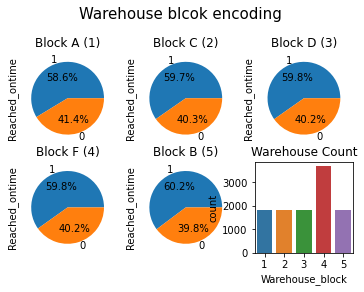

In [7]:
# show why encoding warehouse block from 1 to 5, follow by the growing delay ratio in the warehouse block
fig,ax=plt.subplots(2,3)
df[df['Warehouse_block']==1]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[0,0])
ax[0,0].set_title('Block A (1)')
ax[0,1].set_title('Block C (2)')
ax[0,2].set_title('Block D (3)')
ax[1,0].set_title('Block F (4)')
ax[1,1].set_title('Block B (5)')
ax[1,2].set_title('Warehouse Count')
fig.subplots_adjust(top=0.82)
fig.suptitle('Warehouse blcok encoding', fontsize=15)
df[df['Warehouse_block']==2]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[0,1])
df[df['Warehouse_block']==3]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[0,2])
df[df['Warehouse_block']==4]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[1,0])
df[df['Warehouse_block']==5]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[1,1])
sns.countplot(x='Warehouse_block',data=df,ax=ax[1,2])
plt.show()

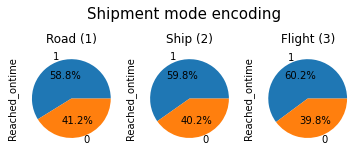

In [8]:
# show why encoding shipment mode as 1-3, follow by the growing delay ratio in the shipment mode
fig,ax=plt.subplots(1,3)
df[df['Shipment_mode']==1]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[0])
df[df['Shipment_mode']==2]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[1])
df[df['Shipment_mode']==3]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.001f%%',ax=ax[2])
ax[0].set_title('Road (1)')
ax[1].set_title('Ship (2)')
ax[2].set_title('Flight (3)')
fig.subplots_adjust(top=1.2)
fig.suptitle('Shipment mode encoding', fontsize=15)
plt.show()

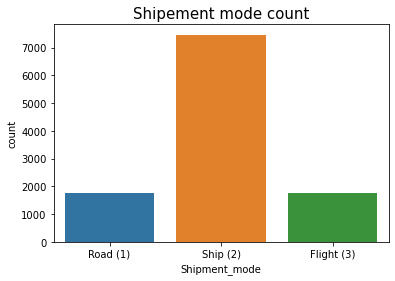

In [9]:
sns.countplot(x='Shipment_mode',data=df).set_xticklabels(['Road (1)','Ship (2)', 'Flight (3)'])
plt.title('Shipement mode count', fontsize=15)
plt.show()

Recategory prior_purchase as 3 groups based on observation other featuers' distribution, machine learning model also shows better result after recatogry prior_purchase feature

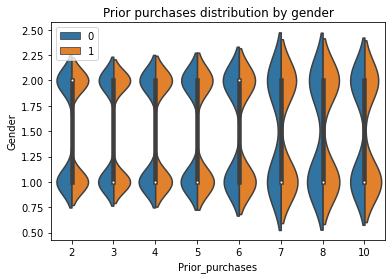

In [10]:
#show why I recatigory prior_purchase into 3 groups
#other features'distributions show 3 groups by prior_purchase(2,3), (4,5,6), (7,8,10)
sns.violinplot(data=df,x='Prior_purchases',y='Gender',hue='Reached_ontime',split=True,)
plt.legend(loc='upper left')
plt.title('Prior purchases distribution by gender')
plt.show()

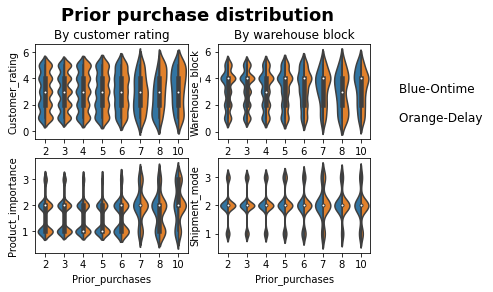

In [11]:
# can set 'Prior_purchases into 3 category'
fig,ax=plt.subplots(2,2)
sns.violinplot(data=df,x='Prior_purchases',y='Customer_rating',hue='Reached_ontime',split=True,ax=ax[0,0])
sns.violinplot(data=df,x='Prior_purchases',y='Warehouse_block',hue='Reached_ontime',split=True,ax=ax[0,1])
sns.violinplot(data=df,x='Prior_purchases',y='Product_importance',hue='Reached_ontime',split=True,ax=ax[1,0])
sns.violinplot(data=df,x='Prior_purchases',y='Shipment_mode',hue='Reached_ontime',split=True,ax=ax[1,1])
#sns.violinplot(data=df,x='Prior_purchases',y='Discount_offered',hue='Reached_ontime',split=True,ax=ax[1,1])
fig.subplots_adjust(top=0.85)
fig.suptitle('Prior purchase distribution', fontsize=18, fontweight='bold')
plt.text(9, 6, 'Blue-Ontime ', fontsize = 12)
plt.text(9, 5, 'Orange-Delay ', fontsize = 12)
ax[0,0].set_title('By customer rating')
ax[0,1].set_title('By warehouse block')
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
plt.show()

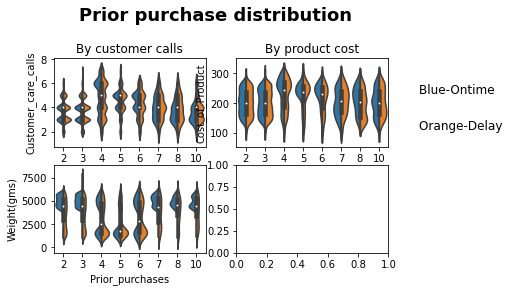

In [12]:
fig,ax=plt.subplots(2,2)
sns.violinplot(data=df,x='Prior_purchases',y='Customer_care_calls',hue='Reached_ontime',split=True,ax=ax[0,0])
sns.violinplot(data=df,x='Prior_purchases',y='Cost_of_Product',hue='Reached_ontime',split=True,ax=ax[0,1])
sns.violinplot(data=df,x='Prior_purchases',y='Weight(gms)',hue='Reached_ontime',split=True,ax=ax[1,0])
ax[0,0].set_title('By customer calls')
ax[0,1].set_title('By product cost')
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
#ax[1,1].get_legend().remove()
fig.subplots_adjust(top=0.8)
fig.suptitle('Prior purchase distribution', fontsize=18, fontweight='bold')
plt.text(1.2, 1.8, 'Blue-Ontime ', fontsize = 12)
plt.text(1.2, 1.4, 'Orange-Delay ', fontsize = 12)
plt.show()

In [13]:
#Recategory prior_purchase as 3 groups
df['Prior_purchases']=df['Prior_purchases'].replace([2,3,4,5,6,7,8,10],[1,1,2,2,2,3,3,3])


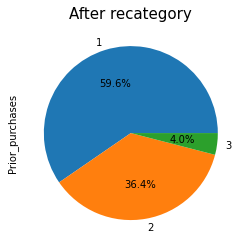

In [14]:
df['Prior_purchases'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('After recategory', fontsize=15)
plt.show()

In [15]:
df.describe()

,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Cost_of_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight(gms),Reached_ontime
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,3.166652,2.001546,4.054459,2.990545,210.196836,1.444313,1.604600,1.495863,13.373216,3634.016729,0.596691
std,1.343711,0.567099,1.141490,1.413603,48.063272,0.572101,0.641464,0.500006,16.205527,1635.377251,0.490584
min,1.000000,1.000000,2.000000,1.000000,96.000000,1.000000,1.000000,1.000000,1.000000,1001.000000,0.000000
25%,2.000000,2.000000,3.000000,2.000000,169.000000,1.000000,1.000000,1.000000,4.000000,1839.500000,0.000000
50%,3.000000,2.000000,4.000000,3.000000,214.000000,1.000000,2.000000,1.000000,7.000000,4149.000000,1.000000
75%,4.000000,2.000000,5.000000,4.000000,251.000000,2.000000,2.000000,2.000000,10.000000,5050.000000,1.000000
max,5.000000,3.000000,7.000000,5.000000,310.000000,3.000000,3.000000,2.000000,65.000000,7846.000000,1.000000


Visualize features' correlation

In [16]:
df.corr()

,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Cost_of_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight(gms),Reached_ontime
Warehouse_block,1.000000,0.000020,-0.000582,0.004803,0.009160,-0.010459,0.002929,0.004071,0.003766,0.003635,0.008864
Shipment_mode,0.000020,1.000000,0.010264,-0.002590,-0.006913,0.007132,0.007679,0.017499,0.001303,-0.003489,0.007797
Customer_care_calls,-0.000582,0.010264,1.000000,0.012209,0.323182,0.290837,-0.058134,0.002545,-0.130750,-0.276615,-0.067126
Customer_rating,0.004803,-0.002590,0.012209,1.000000,0.009270,0.009805,0.003999,0.002775,-0.003124,-0.001897,0.013119
Cost_of_Product,0.009160,-0.006913,0.323182,0.009270,1.000000,0.195925,-0.046789,0.019759,-0.138312,-0.132604,-0.073587
Prior_purchases,-0.010459,0.007132,0.290837,0.009805,0.195925,1.000000,-0.000665,-0.008672,-0.106222,-0.234748,-0.076141
Product_importance,0.002929,0.007679,-0.058134,0.003999,-0.046789,-0.000665,1.000000,-0.002974,0.026023,0.093211,0.020517
Gender,0.004071,0.017499,0.002545,0.002775,0.019759,-0.008672,-0.002974,1.000000,-0.011777,0.003573,0.004689
Discount_offered,0.003766,0.001303,-0.130750,-0.003124,-0.138312,-0.106222,0.026023,-0.011777,1.000000,-0.376067,0.397108
Weight(gms),0.003635,-0.003489,-0.276615,-0.001897,-0.132604,-0.234748,0.093211,0.003573,-0.376067,1.000000,-0.268793


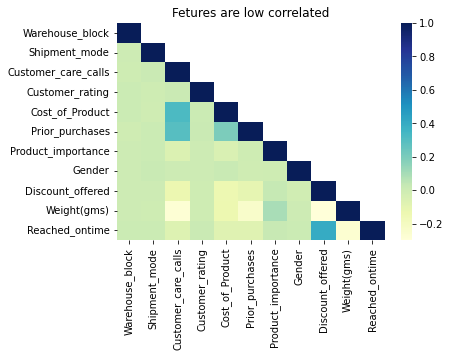

In [17]:
#all features are slightly correlated (corrcoef is between -0.4 and 0.4)
# store side: customer calls is postive correlated with product cost and prior_purchase, store contact buyers
# buyer side: pervious perchase is positive corlated with cost of product
# website and store:Discount_offered is positive correlated with Reached_ontime, high discount, higher delay

# store side:discount offer is negative related weight, positive related reched_ontime: 
            #high discount item has light weight,often to delay
# Reached_ontime is negative corelated with Weight. light and less
# customer_calls is positvie realted with cost_product, nefative related with weight

sns.heatmap(df.corr(),mask=np.triu(np.ones_like(df.corr(), dtype=bool),k=0.5),cmap="YlGnBu",vmin=-0.3, vmax=1).set(title='Fetures are low correlated')
plt.show()

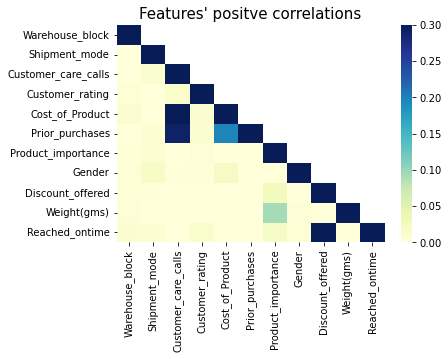

In [18]:
#Visualize correlation for PPT
sns.heatmap(df.corr(),mask=np.triu(np.ones_like(df.corr(), dtype=bool),k=0.5),cmap="YlGnBu",vmin=0, vmax=0.3)
plt.title("Features' positve correlations", fontsize=15)
plt.show()

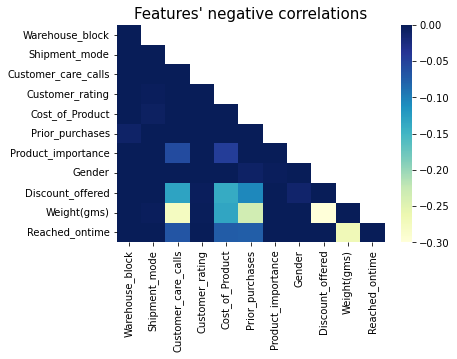

In [19]:
sns.heatmap(df.corr(),mask=np.triu(np.ones_like(df.corr(), dtype=bool),k=1),cmap="YlGnBu",vmin=-0.3, vmax=0)
plt.title("Features' negative correlations", fontsize=15)
plt.show()

# EDA 

In [20]:
df.sample()

,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Cost_of_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight(gms),Reached_ontime
9028,2,1,4,3,187,2,1,2,4,4757,0


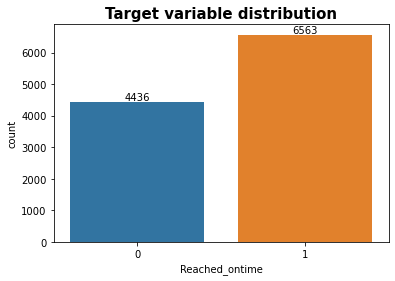

In [21]:
ax=sns.countplot(x='Reached_ontime', data=df)
plt.title('Target variable distribution',fontsize=15, fontweight='bold')
for label in ax.containers:
    ax.bar_label(label)
    plt.show

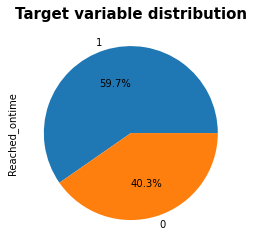

In [22]:
df['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.01f%%')
plt.title('Target variable distribution',fontsize=15, fontweight='bold')
plt.show()

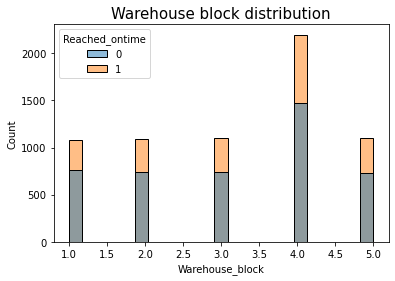

In [23]:
sns.histplot(data=df,x='Warehouse_block',hue='Reached_ontime')
plt.title('Warehouse block distribution',fontsize=15)
plt.show()

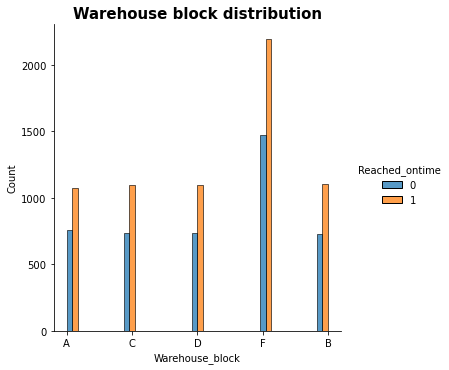

In [24]:
sns.displot(df, x="Warehouse_block", hue="Reached_ontime", multiple="dodge")
plt.title('Warehouse block distribution',fontsize=15, fontweight='bold')
plt.xticks([1,2,3,4,5], labels=['A','C','D','F','B'])
plt.show()

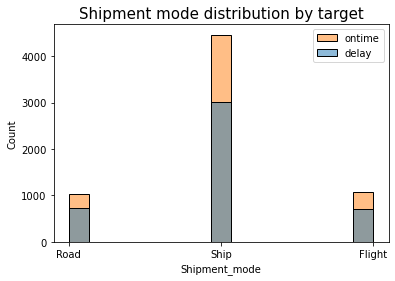

In [25]:
sns.histplot(data=df,x='Shipment_mode', hue='Reached_ontime')
plt.title('Shipment mode distribution by target',fontsize=15)
plt.xticks([1,2,3], labels=['Road','Ship','Flight'])
plt.legend(labels=['ontime','delay'],loc='upper right')
plt.show()

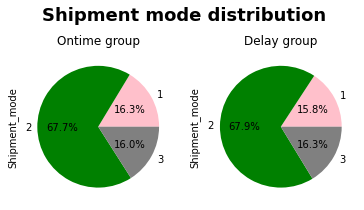

In [26]:
fig,ax=plt.subplots(1,2)
df[df['Reached_ontime']==0]['Shipment_mode'].value_counts().sort_index().plot(kind='pie',autopct='%1.001f%%',
                                                       colors=['pink','green', 'gray', 'yellow', 'blue'],ax=ax[0])
ax[0].set_title('Ontime group')

df[df['Reached_ontime']==1]['Shipment_mode'].value_counts().sort_index().plot(kind='pie',autopct='%1.01f%%',
                                                       colors=['pink','green', 'gray', 'yellow', 'blue'],ax=ax[1])
ax[1].set_title('Delay group')
fig.subplots_adjust(top=1)
fig.suptitle('Shipment mode distribution', fontsize=18, fontweight='bold')

plt.show()

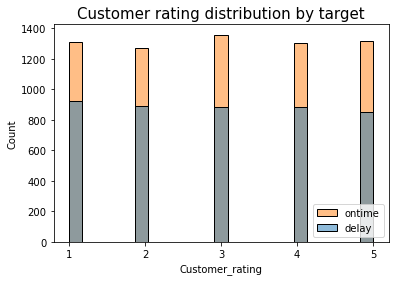

In [27]:
sns.histplot(data=df,x='Customer_rating', hue='Reached_ontime')
plt.xticks([1,2,3,4,5], labels=[1,2,3,4,5])
plt.legend(labels=['ontime','delay'],loc='lower right')
plt.title('Customer rating distribution by target',fontsize=15)
plt.show()

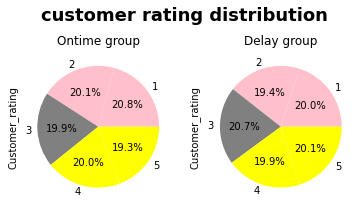

In [28]:
fig,ax=plt.subplots(1,2)
df[df['Reached_ontime']==0]['Customer_rating'].value_counts().sort_index().plot(kind='pie',autopct='%1.001f%%',
                                                       colors=['pink','pink', 'gray', 'yellow', 'yellow'],ax=ax[0])
ax[0].set_title('Ontime group')

df[df['Reached_ontime']==1]['Customer_rating'].value_counts().sort_index().plot(kind='pie',autopct='%1.01f%%',
                                                       colors=['pink','pink', 'gray', 'yellow', 'yellow'],ax=ax[1])
ax[1].set_title('Delay group')
fig.subplots_adjust(top=1)
fig.suptitle('customer rating distribution', fontsize=18, fontweight='bold')

plt.show()

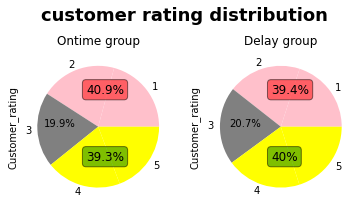

In [29]:
# low customer rating item is easier to deliver ontime (for PPT)
fig,ax=plt.subplots(1,2)
df[df['Reached_ontime']==0]['Customer_rating'].value_counts().sort_index().plot(kind='pie',   
                                                                                colors=['pink','pink', 'gray', 'yellow', 'yellow'],ax=ax[0])
ax[0].set_title('Ontime group')
df[df['Reached_ontime']==1]['Customer_rating'].value_counts().sort_index().plot(kind='pie',  
                                                                                colors=['pink','pink', 'gray', 'yellow', 'yellow'],ax=ax[1])
ax[1].set_title('Delay group')
fig.subplots_adjust(top=1)
fig.suptitle('customer rating distribution', fontsize=18, fontweight='bold')
plt.text(-3.9, 0, '19.9%', fontsize = 10)
plt.text(-0.85, 0, '20.7%', fontsize = 10)
plt.text(-3.2, 0.55, '40.9%', fontsize = 12,bbox = dict(facecolor = 'red', alpha = 0.5,boxstyle='round',edgecolor='black'))
plt.text(-3.2, -0.55, '39.3%', fontsize = 12,bbox = dict(facecolor = 'green', alpha = 0.5,boxstyle='round',edgecolor='black'))
plt.text(-0.16, 0.55, '39.4%', fontsize = 12,bbox = dict(facecolor = 'red', alpha = 0.5,boxstyle='round',edgecolor='black'))
plt.text(-0.16, -0.55, '40%', fontsize = 12,bbox = dict(facecolor = 'green', alpha = 0.5,boxstyle='round',edgecolor='black'))
plt.show()

Product importance

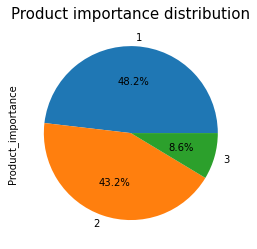

In [30]:
df['Product_importance'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Product importance distribution',fontsize=15)
plt.show()

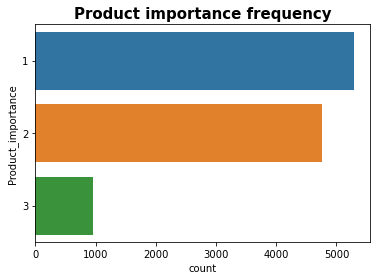

In [31]:
sns.countplot(y='Product_importance',data=df)
plt.title('Product importance frequency',fontsize=15, fontweight='bold')
plt.show()

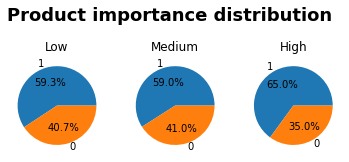

In [32]:
#high importance product is easier to be delay
fig,ax=plt.subplots(1,3)
df[df['Product_importance']==1]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('Low')
ax[0].set_ylabel('')
df[df['Product_importance']==2]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.1f%%',ax=ax[1])
ax[1].set_title('Medium')
ax[1].set_ylabel('')
df[df['Product_importance']==3]['Reached_ontime'].value_counts().plot(kind='pie',autopct='%1.1f%%',ax=ax[2])
ax[2].set_title('High')
ax[2].set_ylabel('')
fig.subplots_adjust(top=1.15)
fig.suptitle('Product importance distribution', fontsize=18, fontweight='bold')
plt.show()

Cost of Product

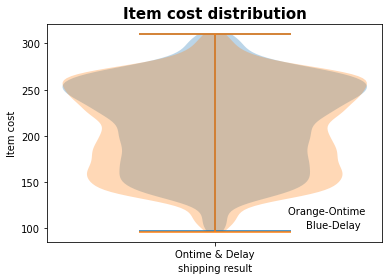

In [33]:
#cost feature not much difference regarding ontime, delay
plt.violinplot(df[df['Reached_ontime']==0]['Cost_of_Product'], positions=[1])
plt.violinplot(df[df['Reached_ontime']==1]['Cost_of_Product'], positions=[1])
plt.title('Item cost distribution',fontsize=15, fontweight='bold')
plt.xticks(ticks=[1],labels=['Ontime & Delay'])
plt.xlabel('shipping result')
plt.ylabel('Item cost')
plt.text(1.12, 115, 'Orange-Ontime ', fontsize = 10)
plt.text(1.15, 100, 'Blue-Delay ', fontsize = 10)
plt.show()

Discount offered

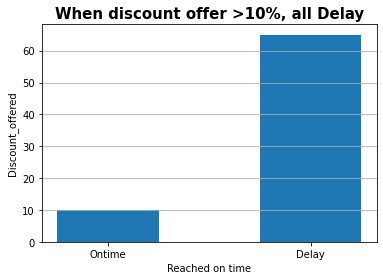

In [34]:
#discount>10, all delay
# discount>10 data might missing in this data set 
plt.bar(df['Reached_ontime'],df['Discount_offered'],width=0.5) 
plt.xticks([0,1],['Ontime','Delay'])
plt.xlabel('Reached on time')
plt.ylabel('Discount_offered')
plt.grid(axis='y')
plt.title('When discount offer >10%, all Delay',fontsize=15, fontweight='bold')
plt.show()

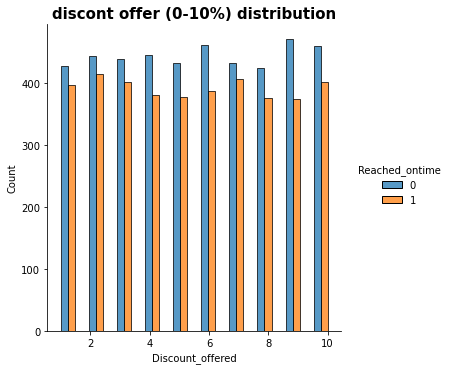

In [35]:
#discount<10, not much difference
sns.displot(df[df['Discount_offered']<=10], x="Discount_offered", hue="Reached_ontime", multiple="dodge")
plt.title('discont offer (0-10%) distribution',fontsize=15, fontweight='bold')
plt.show()

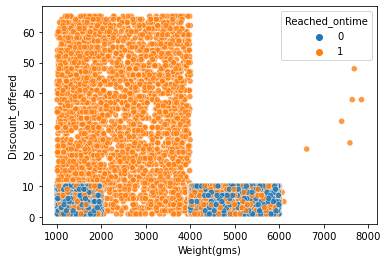

In [36]:
sns.scatterplot(data=df,x=df['Weight(gms)'], y=df['Discount_offered'],hue=df['Reached_ontime'],alpha=0.8)
plt.show()

Weight(gms)

Text(0.5, 1.0, 'Item weight distribution')

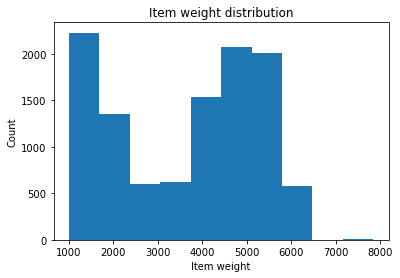

In [37]:
plt.hist(df['Weight(gms)'], bins=10)
plt.xlabel('Item weight')
plt.ylabel('Count')
plt.title('Item weight distribution')

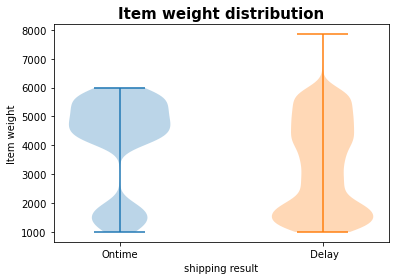

In [38]:
# data might missing item weight 2000-4000 ontime
plt.violinplot(df[df['Reached_ontime']==0]['Weight(gms)'], positions=[1])
plt.violinplot(df[df['Reached_ontime']==1]['Weight(gms)'], positions=[2])
plt.title('Item weight distribution',fontsize=15, fontweight='bold')
plt.xticks(ticks=[1,2],labels=['Ontime',' Delay'])
plt.xlabel('shipping result')
plt.ylabel('Item weight')
plt.show()

C:\Users\tianq\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tianq\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


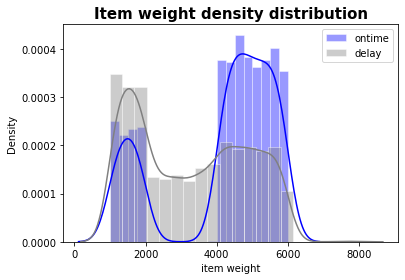

In [39]:
#when weight<2000, item has high posibility be delay, whne weigh>4000, item is easy to be ontime
sns.distplot(x=df[df['Reached_ontime']==0]['Weight(gms)'],  bins=20, color='blue',
             hist_kws={"edgecolor": 'white'}, label='ontime')
sns.distplot(x=df[df['Reached_ontime']==1]['Weight(gms)'], bins=20, color='grey',
             hist_kws={"edgecolor": 'white'}, label='delay')
plt.title('Item weight density distribution',fontsize=15, fontweight='bold')
plt.xlabel('item weight')
plt.legend()
plt.show()

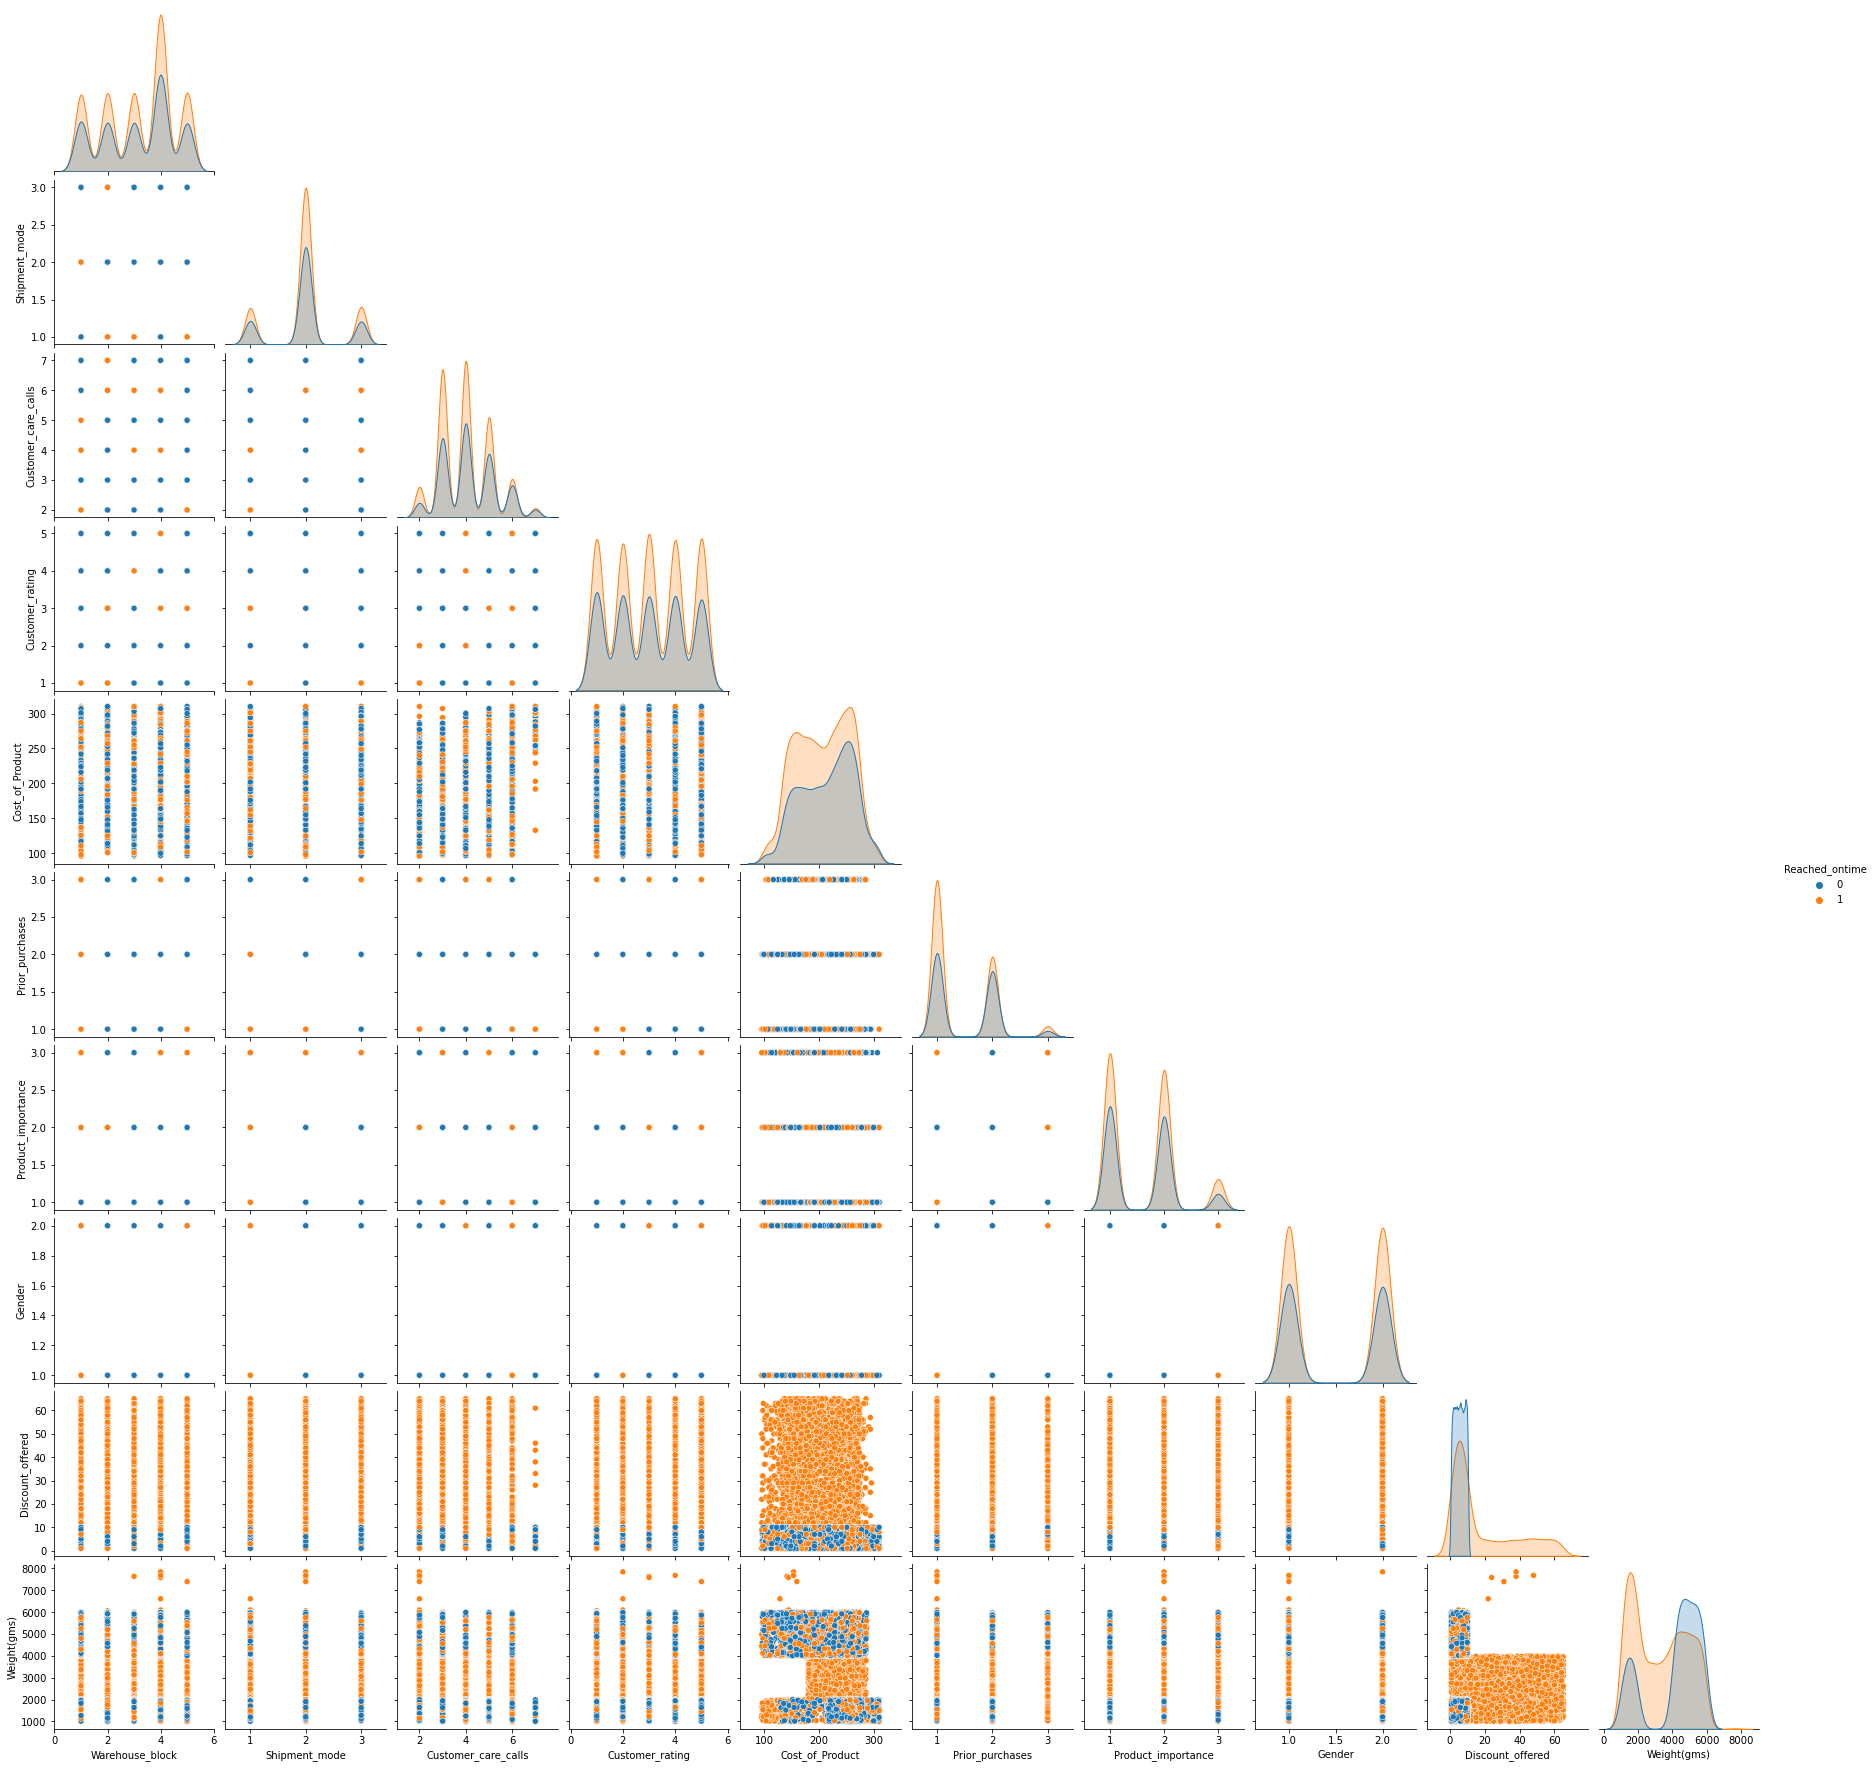

In [40]:
#show featus'distribution by target variable
sns.pairplot(df,hue='Reached_ontime',corner=True)

# analysis what I need to get from the model

# Build model

In [41]:
df.columns

Index(['Warehouse_block', 'Shipment_mode', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight(gms)',
       'Reached_ontime'],
      dtype='object')

# Select all features' model, all models perform similar Acc and Recall score

In [42]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
df.iloc[:,:-1] = stand.fit_transform(df.iloc[:,:-1])

train, test = train_test_split(df, test_size=0.2, random_state=20)
X_train=train[[ 'Warehouse_block', 'Shipment_mode', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight(gms)']]
y_train=train['Reached_ontime']
X_test=test[[ 'Warehouse_block', 'Shipment_mode', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight(gms)',]]
y_test=test['Reached_ontime']
print('trainset has data:', X_train.shape[0])
print('testset has data:', X_test.shape[0])

trainset has data: 8799
testset has data: 2200


In [43]:
def f(a):
    b="{0:.2}".format(a)
    return float(b)

Logistic Regression Feature importance [[-0.00361685  0.02543392 -0.1028011   0.03710539 -0.11163495 -0.16922216
   0.0844091   0.00659888  1.76998547 -0.4258497 ]]


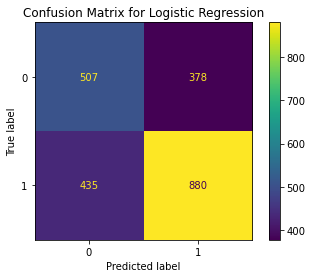

              precision    recall  f1-score   support

           0       0.54      0.57      0.56       885
           1       0.70      0.67      0.68      1315

    accuracy                           0.63      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.63      0.63      0.63      2200



In [44]:
#logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear',random_state=0).fit(X_train, y_train)
print('Logistic Regression Feature importance',lr.coef_)
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test).ax_.set_title('Confusion Matrix for Logistic Regression')
plt.show()
print(classification_report(y_test, lr.predict(X_test)))

SVC Feature importance [[-0.00486354  0.02952131 -0.06081799  0.03441427 -0.0421982  -0.12492551
   0.06542957  0.00861949  1.00328303 -0.73637794]]


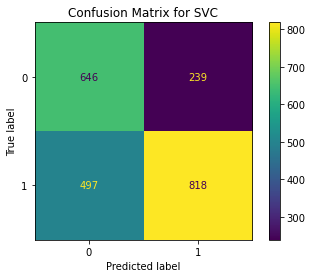

              precision    recall  f1-score   support

           0       0.57      0.73      0.64       885
           1       0.77      0.62      0.69      1315

    accuracy                           0.67      2200
   macro avg       0.67      0.68      0.66      2200
weighted avg       0.69      0.67      0.67      2200



In [45]:
#svc
from sklearn.svm import SVC
svc=SVC(kernel="linear",random_state=0).fit(X_train,y_train)
print('SVC Feature importance',svc.coef_)
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test).ax_.set_title('Confusion Matrix for SVC')
plt.show()
print(classification_report(y_test, svc.predict(X_test)))

[0.         0.         0.         0.         0.00148621 0.
 0.00348066 0.         0.50024558 0.49478755]


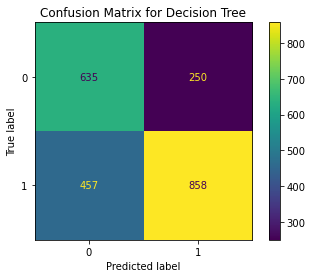

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       885
           1       0.77      0.65      0.71      1315

    accuracy                           0.68      2200
   macro avg       0.68      0.68      0.68      2200
weighted avg       0.70      0.68      0.68      2200



In [46]:
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(criterion='entropy', max_depth=3,max_features=0.8, random_state=0).fit(X_train,y_train)
print(dc.feature_importances_)
ConfusionMatrixDisplay.from_estimator(dc, X_test, y_test).ax_.set_title('Confusion Matrix for Decision Tree')
plt.show()
print(classification_report(y_test, dc.predict(X_test)))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.81427019e-05
 2.14661015e-04 3.07299072e-03 6.81297717e-04 0.00000000e+00
 8.83714001e-01 1.12258907e-01]


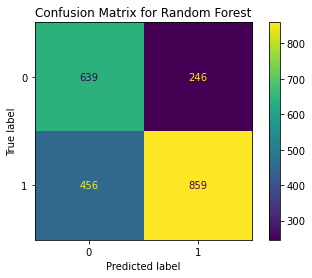

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       885
           1       0.78      0.65      0.71      1315

    accuracy                           0.68      2200
   macro avg       0.68      0.69      0.68      2200
weighted avg       0.70      0.68      0.68      2200



In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=2, max_features=0.9, random_state=0).fit(X_train,y_train)
print(rf.feature_importances_)
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test).ax_.set_title('Confusion Matrix for Random Forest')
plt.show()
print(classification_report(y_test, rf.predict(X_test)))

[0.   0.01 0.01 0.01 0.11 0.03 0.01 0.   0.02 0.8 ]


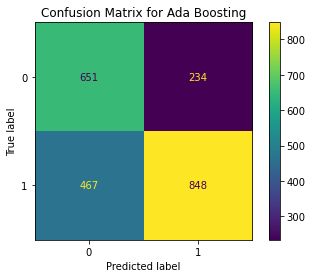

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       885
           1       0.78      0.64      0.71      1315

    accuracy                           0.68      2200
   macro avg       0.68      0.69      0.68      2200
weighted avg       0.70      0.68      0.68      2200



In [48]:
from sklearn.ensemble import AdaBoostClassifier
ab= AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=0).fit(X_train, y_train)
print(ab.feature_importances_)
ConfusionMatrixDisplay.from_estimator(ab, X_test, y_test).ax_.set_title('Confusion Matrix for Ada Boosting')
plt.show()
print(classification_report(y_test, ab.predict(X_test)))

[0.00098307 0.00089839 0.00980157 0.00634996 0.09996664 0.0884178
 0.00172784 0.         0.1820468  0.60980792]


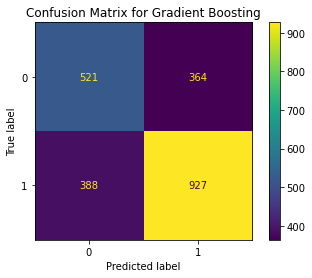

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       885
           1       0.72      0.70      0.71      1315

    accuracy                           0.66      2200
   macro avg       0.65      0.65      0.65      2200
weighted avg       0.66      0.66      0.66      2200



In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gb= GradientBoostingClassifier(n_estimators=100, learning_rate=2,loss='exponential', max_depth=3, random_state=0).fit(X_train, y_train)
print(gb.feature_importances_)
ConfusionMatrixDisplay.from_estimator(gb, X_test, y_test).ax_.set_title('Confusion Matrix for Gradient Boosting')
plt.show()
print(classification_report(y_test, gb.predict(X_test)))

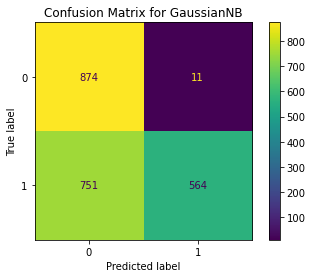

              precision    recall  f1-score   support

           0       0.54      0.99      0.70       885
           1       0.98      0.43      0.60      1315

    accuracy                           0.65      2200
   macro avg       0.76      0.71      0.65      2200
weighted avg       0.80      0.65      0.64      2200



In [50]:
# navie bayer
from sklearn.naive_bayes import GaussianNB
nb= GaussianNB()
nb.fit(X_train,y_train)
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test).ax_.set_title('Confusion Matrix for GaussianNB')
plt.show()
print(classification_report(y_test, nb.predict(X_test)))

accuracy 0.6354545454545455


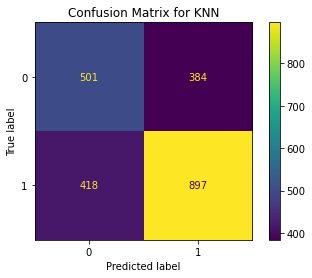

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       885
           1       0.70      0.68      0.69      1315

    accuracy                           0.64      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.64      0.64      0.64      2200



In [51]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
print('accuracy',kn.score(X_test,y_test))
ConfusionMatrixDisplay.from_estimator(kn, X_test, y_test).ax_.set_title('Confusion Matrix for KNN')
plt.show()
print(classification_report(y_test, kn.predict(X_test)))

In [52]:
from sklearn.feature_selection import SequentialFeatureSelector as seq
from sklearn.feature_selection import RFE
select=RFE(estimator=RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=3,max_features=0.9, random_state=0), n_features_to_select=1, step=1)
select.fit(X_train,y_train)
print('RFE ranking',select.ranking_)
sfs = seq(RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=3,max_features=0.9, random_state=0), 
          n_features_to_select=5,cv=5,scoring="roc_auc",n_jobs=-1,direction='forward').fit(X_train,y_train)
print('sfs_support',sfs.get_support())

RFE ranking [10  8  7  6  4  3  5  9  1  2]
sfs_support [False False  True False False  True  True False  True  True]


In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_principal = pca.fit(X_train)

pca.explained_variance_ratio_

array([0.17524553, 0.13440703, 0.10214136])

In [54]:
pca.components_

array([[-4.20339353e-03,  2.14064174e-02,  5.63751403e-01,
         3.60932009e-02,  4.57291642e-01,  4.92960402e-01,
        -1.35033757e-01,  1.39599858e-02, -1.36799667e-02,
        -4.57890807e-01],
       [-1.67208285e-02,  3.77684986e-02, -1.45784498e-01,
        -1.23659712e-02, -2.59359846e-01, -9.34412590e-02,
        -2.57611204e-02, -4.95383482e-02,  7.67935965e-01,
        -5.55018728e-01],
       [ 5.96640291e-01,  3.07282785e-01,  4.16727147e-04,
         3.20486673e-01,  4.48810671e-02, -6.80657942e-02,
         1.23171236e-01,  6.50126676e-01,  4.75957749e-02,
        -1.17176377e-02]])

delete last 3 featuers(Warehouse block, Shipment, Gender) from RFE featue selection, build model again, PCA also shows 7 features' model is better than 10 features' model

In [55]:
X_train=train[[ 'Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance', 'Discount_offered', 'Weight(gms)']]
#y_train=train['Reached_ontime']
X_test=test[[ 'Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance','Discount_offered', 'Weight(gms)']]
#y_test=test['Reached_ontime']
print('Select X feautes:', X_test.shape[1])

Select X feautes: 7


In [56]:
#PCA first and second explained_variance_ratio increased after reduce 3 features
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_principal = pca.fit(X_train)

pca.explained_variance_ratio_


array([0.25053357, 0.19200002, 0.14417821])

In [57]:
pca.components_

array([[ 0.56379976,  0.03628053,  0.45746945,  0.4933074 , -0.13525982,
        -0.0138143 , -0.45792686],
       [-0.14626859, -0.01043317, -0.25770502, -0.09556512, -0.02635711,
         0.76960863, -0.55674046],
       [ 0.01279266,  0.84006245, -0.01142997,  0.09239542,  0.53197382,
         0.04824583,  0.01183535]])

run all other models above, display results

In [58]:
X_train.shape

(8799, 7)

In [59]:
lr = LogisticRegression(solver='liblinear',random_state=0).fit(X_train, y_train)
print('Logistic regression recall',f(recall_score(y_test, lr.predict(X_test))), 'precision',
      f(precision_score(y_test, lr.predict(X_test))), 'acc', f(accuracy_score(y_test, lr.predict(X_test))))
svc=SVC(kernel="linear",random_state=0).fit(X_train,y_train)
print('SVC                 recall',  f(recall_score(y_test, svc.predict(X_test))), 'precision', 
      f(precision_score(y_test, svc.predict(X_test))), 'acc', f(accuracy_score(y_test, svc.predict(X_test))))
dc = DecisionTreeClassifier(criterion='entropy', max_depth=2,max_features=0.8, random_state=0).fit(X_train,y_train)
print('Decision Tree       recall', f(recall_score(y_test, dc.predict(X_test))), 'precision', 
      f(precision_score(y_test, dc.predict(X_test))), 'acc', f(accuracy_score(y_test, dc.predict(X_test))))
rf = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=2, max_features=0.9, random_state=0).fit(X_train,y_train)
print('Random Forest       recall', f(recall_score(y_test, rf.predict(X_test))), 'precision', 
      f(precision_score(y_test, rf.predict(X_test))), 'acc', f(accuracy_score(y_test, rf.predict(X_test))))
ab= AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=0).fit(X_train, y_train)
print('Ada Boosting        recall',  f(recall_score(y_test, ab.predict(X_test))), 'precision', 
      f(precision_score(y_test, ab.predict(X_test))), 'acc', f(accuracy_score(y_test, ab.predict(X_test))))
gb= GradientBoostingClassifier(n_estimators=100, learning_rate=2,loss='exponential', max_depth=3, random_state=0).fit(X_train, y_train)
print('Gradient Boosting   recall',  f(recall_score(y_test, gb.predict(X_test))), 'precision', 
      f(precision_score(y_test, gb.predict(X_test))), 'acc', f(accuracy_score(y_test, gb.predict(X_test))))
nb= GaussianNB().fit(X_train,y_train)
print('GaussianNB          recall',  f(recall_score(y_test, nb.predict(X_test))), 'precision', 
      f(precision_score(y_test, nb.predict(X_test))), 'acc', f(accuracy_score(y_test, nb.predict(X_test))))
kn=KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
print('K Nearest Neighbors recall',  f(recall_score(y_test, kn.predict(X_test))), 'precision', 
      f(precision_score(y_test, kn.predict(X_test))), 'acc', f(accuracy_score(y_test, kn.predict(X_test))))

Logistic regression recall 0.67 precision 0.7 acc 0.63
SVC                 recall 0.62 precision 0.78 acc 0.67
Decision Tree       recall 0.65 precision 0.77 acc 0.68
Random Forest       recall 0.65 precision 0.78 acc 0.68
Ada Boosting        recall 0.65 precision 0.77 acc 0.68
Gradient Boosting   recall 0.72 precision 0.71 acc 0.66
GaussianNB          recall 0.43 precision 0.98 acc 0.65
K Nearest Neighbors recall 0.69 precision 0.7 acc 0.64


# Build my model (Random Forest-Gradient Boosting)

Model part 1: Random Forest

trainset acc: 0.67 recall: 0.64


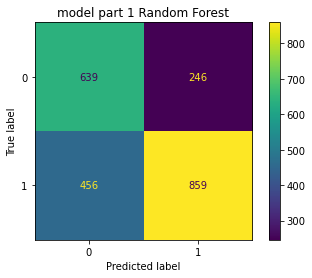

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       885
           1       0.78      0.65      0.71      1315

    accuracy                           0.68      2200
   macro avg       0.68      0.69      0.68      2200
weighted avg       0.70      0.68      0.68      2200



In [60]:
#model1: Random Forest
rr = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=2,max_features=0.9, random_state=0).fit(X_train,y_train)

print('trainset acc:',f(rr.score(X_train,y_train)),'recall:',f(recall_score(y_train,rr.predict(X_train))))
ConfusionMatrixDisplay.from_estimator(rr, X_test, y_test).ax_.set_title('model part 1 Random Forest')
plt.show()
print(classification_report(y_test, rr.predict(X_test)))

Prepare data for second model from trainset

In [61]:
# only select first model prediction=0 data as second model's trainset
# first model and second modeltraining process doesn't touch testset data
train['first_pred']=rr.predict(X_train)
test['first_pred']=rr.predict(X_test)
newtrain=train[train['first_pred']==0]
X1_train=newtrain[['Customer_care_calls',
       'Customer_rating', 'Cost_of_Product', 'Prior_purchases',
       'Product_importance', 'Discount_offered', 'Weight(gms)']]
y1_train=newtrain['Reached_ontime']
print('trainset for second model has data:',X1_train.shape[0])

trainset for second model has data: 4488


Model part 2: Gradient Boosting

In [62]:
#use for loop to find optimal learning rate (1.8) in the model2
from sklearn.ensemble import GradientBoostingClassifier
small_train_acc=[]
small_train_roc_auc=[]
whole_trainset_acc=[]
whole_trainset_recall=[]
whole_trainset_precision=[]
testset_acc=[]
testset_recall=[]
testset_precision=[]
for b in np.linspace(0.1,2,20):
    mm= GradientBoostingClassifier(n_estimators=100, learning_rate=b,loss='exponential', max_depth=2, random_state=0).fit(X1_train,y1_train)
    small_train_acc.append(f(mm.score(X1_train,y1_train)))
    small_train_roc_auc.append(f(roc_auc_score(y1_train, mm.predict_proba(X1_train)[:, 1])))
    train['second_pred']=mm.predict(X_train)
    train['prediction']=train['Reached_ontime']
    for a in range(train.shape[0]):
        if train.iloc[a,-3]==1:
            train.iloc[a,-1]=1
        else:
            train.iloc[a,-1]=train.iloc[a,-2]
    whole_trainset_acc.append(f(accuracy_score(train['Reached_ontime'],train['prediction'])))
    whole_trainset_recall.append(f(recall_score(train['Reached_ontime'],train['prediction'])))
    whole_trainset_precision.append(f(precision_score(train['Reached_ontime'],train['prediction'])))
    test['second_pred']=mm.predict(X_test)
    test['prediction']=test['Reached_ontime']
    for a in range(test.shape[0]):
        if test.iloc[a,-3]==1:
            test.iloc[a,-1]=1
        else:
            test.iloc[a,-1]=test.iloc[a,-2]
    testset_acc.append(f(accuracy_score(test['Reached_ontime'],test['prediction'])))
    testset_recall.append(f(recall_score(test['Reached_ontime'],test['prediction'])))
    testset_precision.append(f(precision_score(test['Reached_ontime'],test['prediction'])))

In [63]:
#data_rate shows acc, recall and precision when choose model2 learning rate from 0.1 to 2
data_rate=pd.DataFrame()
data_rate['learn_rate']=np.linspace(0.1,2,20)
data_rate['small_train_acc']=small_train_acc
data_rate['small_train_roc_auc']=small_train_roc_auc
data_rate['whole_trainset_acc']=whole_trainset_acc
data_rate['whole_trainset_recall']=whole_trainset_recall
data_rate['whole_trainset_precision']=whole_trainset_precision
data_rate['testset_acc']=testset_acc
data_rate['testset_recall']=testset_recall
data_rate['testset_precision']=testset_precision
data_rate

,learn_rate,small_train_acc,small_train_roc_auc,whole_trainset_acc,whole_trainset_recall,whole_trainset_precision,testset_acc,testset_recall,testset_precision
0,0.1,0.59,0.63,0.68,0.66,0.77,0.68,0.67,0.76
1,0.2,0.61,0.66,0.69,0.69,0.77,0.68,0.70,0.75
2,0.3,0.63,0.68,0.70,0.72,0.77,0.67,0.71,0.74
3,0.4,0.64,0.70,0.71,0.73,0.76,0.67,0.72,0.73
4,0.5,0.65,0.71,0.71,0.75,0.76,0.67,0.74,0.71
5,0.6,0.66,0.72,0.72,0.77,0.76,0.66,0.75,0.70
6,0.7,0.66,0.72,0.71,0.78,0.75,0.67,0.76,0.71
7,0.8,0.66,0.72,0.72,0.79,0.75,0.66,0.75,0.70
8,0.9,0.67,0.73,0.72,0.80,0.75,0.65,0.75,0.69
9,1.0,0.67,0.73,0.72,0.80,0.75,0.66,0.76,0.70


small train accuracy 0.66 roc_auc 0.72


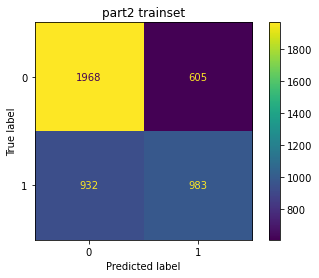

whole trainset acc 0.71
whole trainset recall 0.82
whole trainset precision 0.73


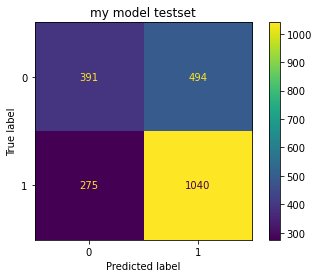

              precision    recall  f1-score   support

           0       0.59      0.44      0.50       885
           1       0.68      0.79      0.73      1315

    accuracy                           0.65      2200
   macro avg       0.63      0.62      0.62      2200
weighted avg       0.64      0.65      0.64      2200



In [64]:
#model2:GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier
mm= GradientBoostingClassifier(n_estimators=100, learning_rate=1.8,loss='exponential', max_depth=2, random_state=0).fit(X1_train,y1_train)


print('small train accuracy',f(mm.score(X1_train,y1_train)),'roc_auc',f(roc_auc_score(y1_train, mm.predict_proba(X1_train)[:, 1])))
ConfusionMatrixDisplay.from_estimator(mm, X1_train, y1_train).ax_.set_title('part2 trainset')
plt.show()

train['second_pred']=mm.predict(X_train)
train['prediction']=train['Reached_ontime']
#update trainset prediction based on model 1 and model 2 outcome. 
#when firt model predict as 1, final prediction=1; when first model predict 0, second model prediction is final prediction
for a in range(train.shape[0]):
    if train.iloc[a,-3]==1:
        train.iloc[a,-1]=1
    else:
        train.iloc[a,-1]=train.iloc[a,-2]

print('whole trainset acc',f(accuracy_score(train['Reached_ontime'],train['prediction'])))
print('whole trainset recall',f(recall_score(train['Reached_ontime'],train['prediction'])))
print('whole trainset precision',f(precision_score(train['Reached_ontime'],train['prediction'])))

#ConfusionMatrixDisplay.from_predictions(train['Reached_ontime'],train['prediction'])   
#print(classification_report(train['Reached_ontime'],train['prediction']))


test['second_pred']=mm.predict(X_test)
test['prediction']=test['Reached_ontime']
for a in range(test.shape[0]):
    if test.iloc[a,-3]==1:
        test.iloc[a,-1]=1
    else:
        test.iloc[a,-1]=test.iloc[a,-2]

ConfusionMatrixDisplay.from_predictions(test['Reached_ontime'],test['prediction']).ax_.set_title('my model testset')
plt.show()
print(classification_report(test['Reached_ontime'],test['prediction']))


Display stacking method by choosing part1 and part2 as estimatiors, stacking result is not good. 
Therefore, my model perform better to detect delay shipping

accuracy trainset 0.65
roc_auc trainset 0.73 testset 0.75
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       885
           1       0.73      0.73      0.73      1315

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.67      0.67      0.67      2200



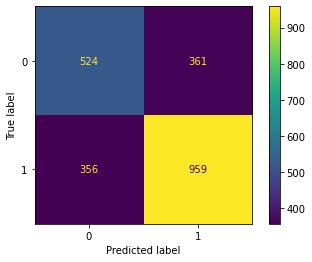

In [67]:
from sklearn.ensemble import StackingClassifier
estimator=[('dc',RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=2,max_features=0.9, random_state=0))]

st = StackingClassifier(
    estimators=estimator,
    final_estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=1.8,loss='exponential', max_depth=2, random_state=0))
st.fit(X_train,y_train)
print('accuracy trainset',f(st.score(X_train,y_train)))
ConfusionMatrixDisplay.from_estimator(st, X_test, y_test)
print('roc_auc trainset',f(roc_auc_score(y_train, st.predict_proba(X_train)[:, 1])),
      'testset',f(roc_auc_score(y_test, st.predict_proba(X_test)[:, 1])))
print(classification_report(y_test, st.predict(X_test)))

# Visulize my model result

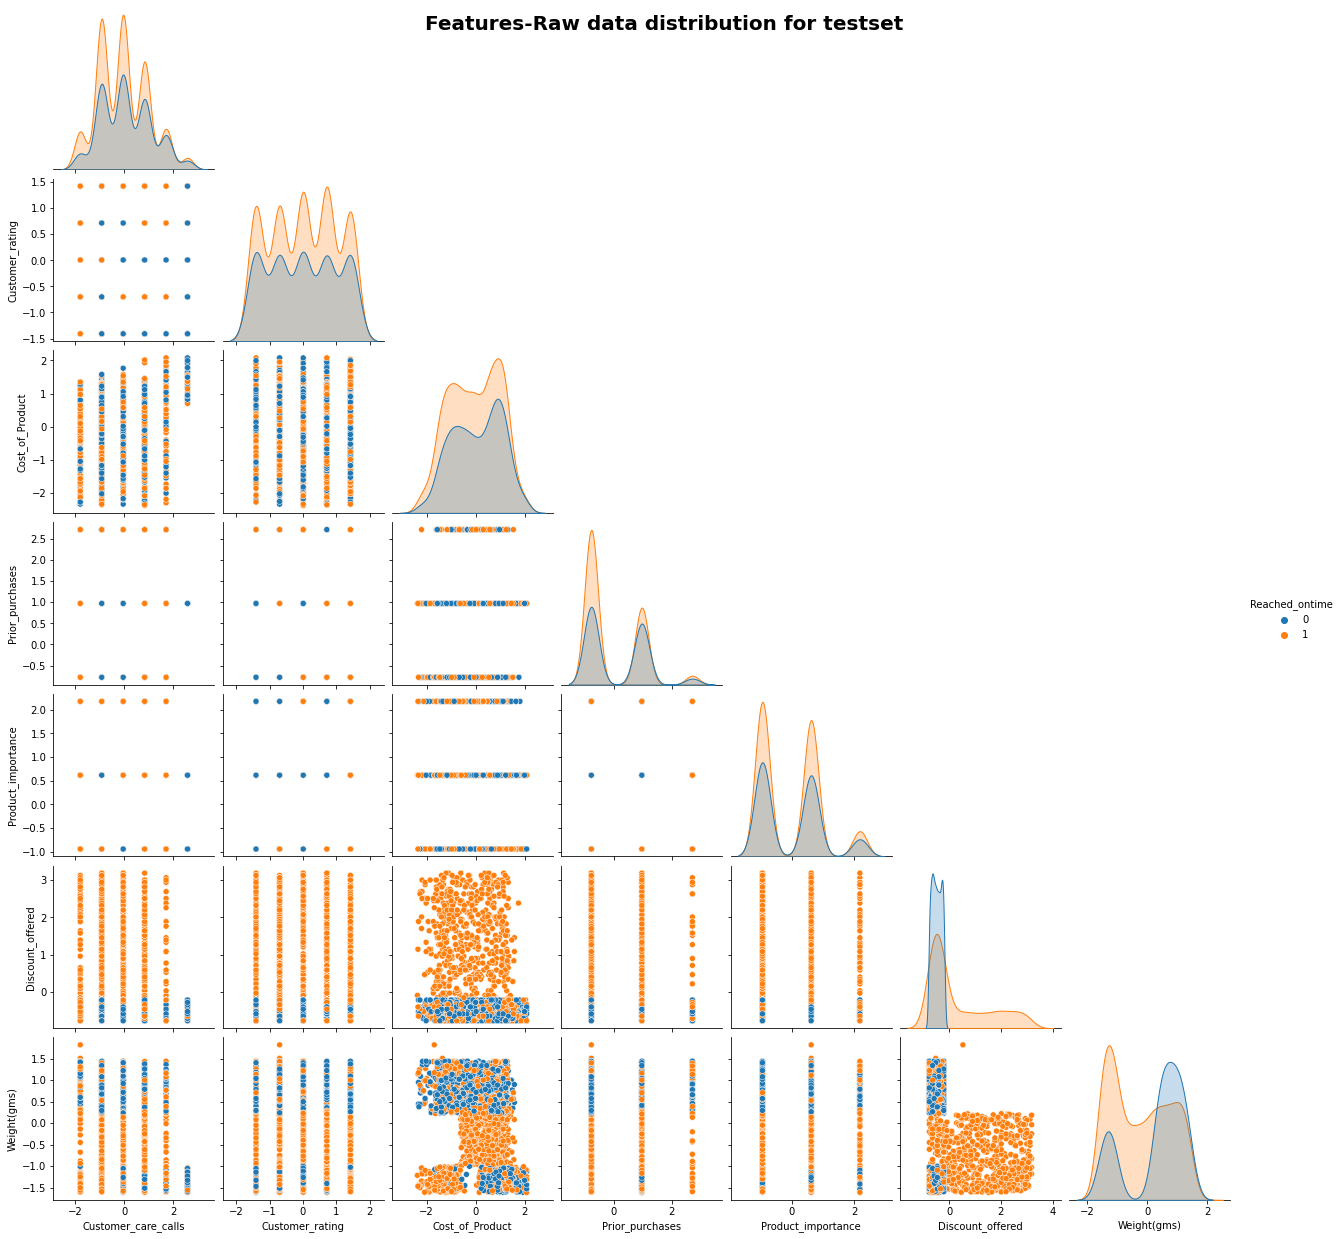

In [74]:
# Testset orignial data distribution
sns.pairplot(test[['Customer_care_calls','Customer_rating', 'Cost_of_Product', 'Prior_purchases',
                   'Product_importance', 'Discount_offered', 'Weight(gms)','Reached_ontime']]
                   ,hue='Reached_ontime',corner=True).fig.suptitle("Features-Raw data distribution for testset",fontsize=20, fontweight='bold')
plt.show()

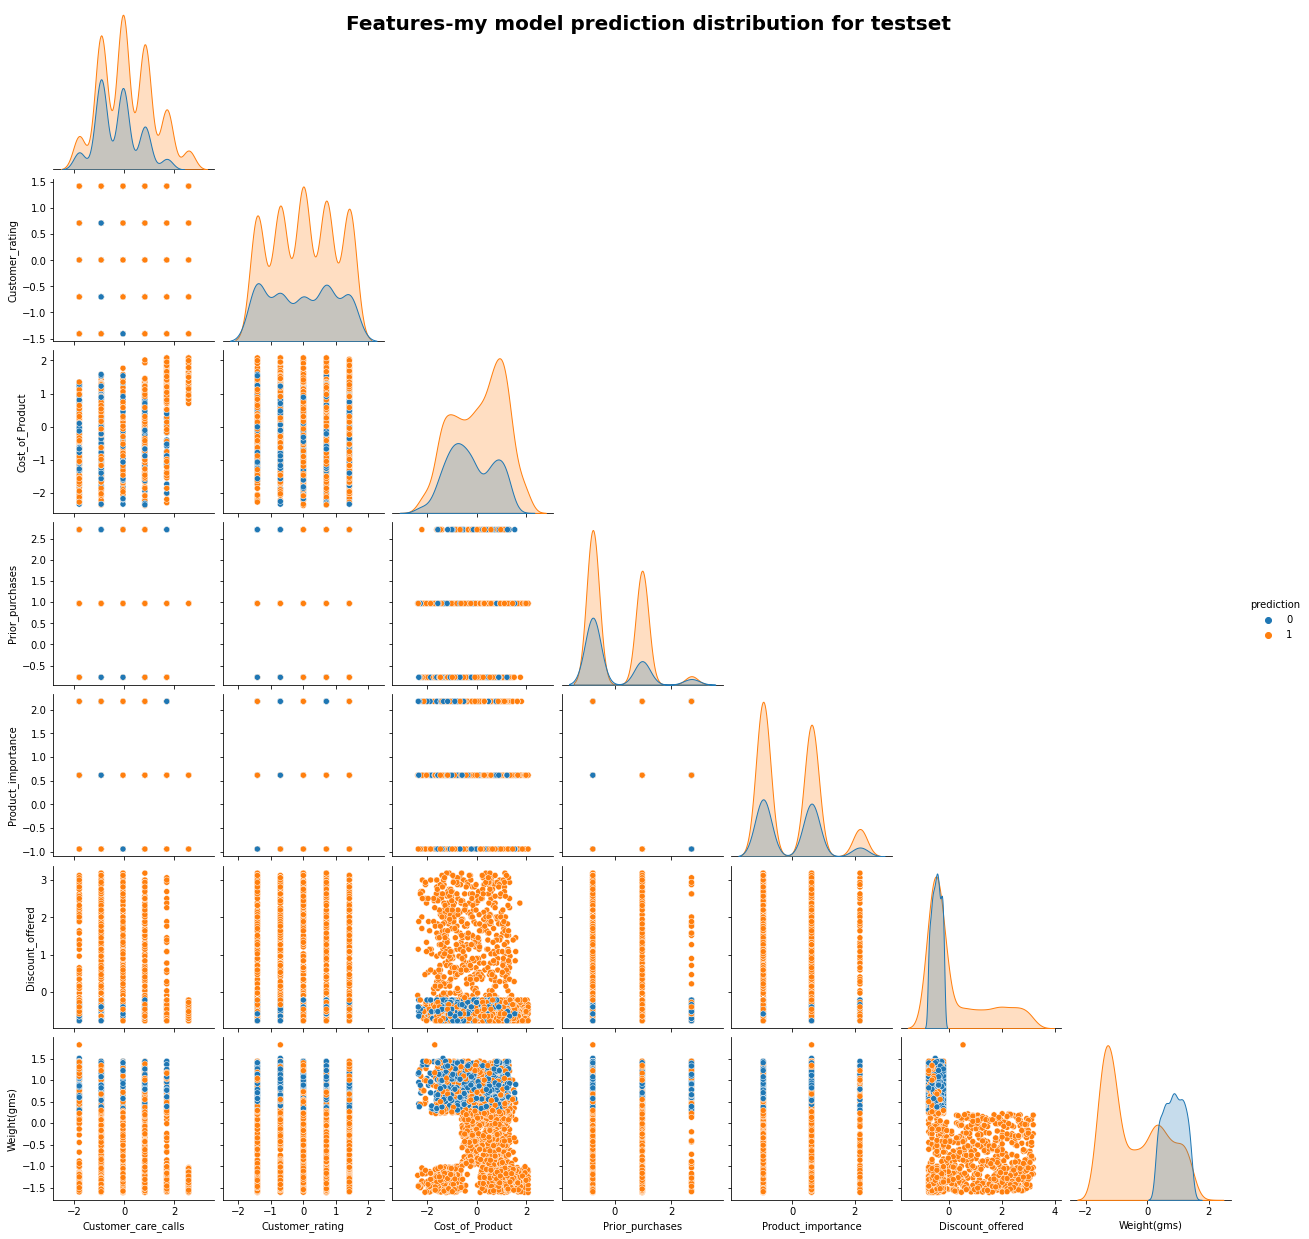

In [75]:
sns.pairplot(test[['Customer_care_calls','Customer_rating', 'Cost_of_Product', 'Prior_purchases',
                   'Product_importance', 'Discount_offered', 'Weight(gms)','prediction']],hue='prediction',corner=True
            ).fig.suptitle("Features-my model prediction distribution for testset",fontsize=20, fontweight='bold')
plt.show()

# Calculate testset data cost for models example 

In [68]:
# if no model,testset will have 1315 items shipping delay, cost: 1,315*10=13,150
y_test.value_counts()

1    1315
0     885
Name: Reached_ontime, dtype: int64

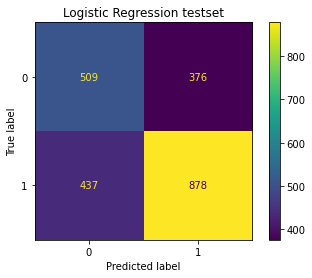

In [72]:
#logistic Regression model cost: 437*10 + (376+878)= 5,624
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test).ax_.set_title('Logistic Regression testset')
plt.show()

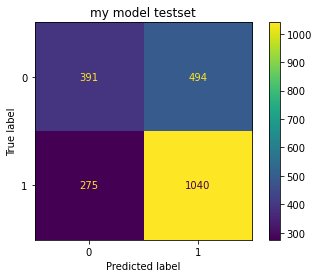

In [73]:
#my model testset cost= 275*10 + (494+1040)= 4,284
ConfusionMatrixDisplay.from_predictions(test['Reached_ontime'],test['prediction']).ax_.set_title('my model testset')
plt.show()

Calculate intangible cost breakeven point (B) 